In this notebook, we are going to explore the eigenstate thermalization hypothesis (ETH) and thermalization in quenches from initial states.

Some useful references:
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

3. D'Alessio, Kafri, Polkovnikov, Rigol, From Quantum Chaos and Eigenstate Thermalization to Statistical Mechanics and Thermodynamics; https://arxiv.org/abs/1509.06411 (longer review article)




# Useful Functions #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy import linalg
import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L):
        tot = tot + op_list[i]
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

def gen_state_bloch(thetaList, phiList):
    L=len(thetaList)
    psi = np.kron([np.cos(thetaList[0]/2.),np.exp(1j*phiList[0])*np.sin(thetaList[0]/2.)],
                  [np.cos(thetaList[1]/2.),np.exp(1j*phiList[1])*np.sin(thetaList[1]/2.)])
    for i in range(2,L):
        psi = np.kron(psi, [np.cos(thetaList[i]/2.),np.exp(1j*phiList[i])*np.sin(thetaList[i]/2.)])
    return psi


In [ ]:
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111,
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )
    # plot
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

# Model #

As a model Hamiltonian, we'll work with the transverse field Ising model (TFIM) with an additional longitudinal field:

$H = J \sum_i \sigma_i^z \sigma_{i+1}^z + h_x\sum_i \sigma_i^x  + h_z \sum_i \sigma_i^z $

When $h_z=0$, this is the TFIM you looked at in the last HW. The TFIM can be re-written as a model of non-interacting Majorana fermions and is thus a `free' integrable model. The additional longitudinal field with strength $h_z$ makes the model non-integrable and breaks the Ising symmetry.

Choose your parameters as below:


In [ ]:
J=1
hz = (np.sqrt(5)+1)/4.
hx = (np.sqrt(5)+5)/8.
BC = 'obc'

The choice of parameters above may seem strange. They are chosen from this paper: https://arxiv.org/abs/1306.4306 and these parameters have been found to make the model robustly non-integrable even at small sizes. While any non-zero $h_z$ is non-integrable, in practice one may need to go to very large sizes and/or very late times to see this.

# Question 1: Energy and Entropy (15 pts) #

a. Construct and diagonalize the Hamiltonian for the model above for L=12 (use the helper functions). Plot the normalized distribution of eigenenergies as a function of energy using plt.hist or np.histogram. This serves as a proxy for the density of states (DOS). [5pts]

b. What is the shape of the DOS? Next week, we will contrast this DOS with that of a dense random matrix, which has a semicircular DOS.  [1pt]

c. The bandwith of a spectrum is defined as the difference in energy between the highest and lowest energy states. How does the bandwidth scale with system size $L$? It is preferred for you to answer this part by general analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. [1pt]

d. How does the standard deviation of the DOS scale with $L$? This represents the energy window where most of the eigenstates live, which scales differently from the bandwidth. It is preferred for you to answer this part by analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. Your analytic answer can be given on general terms and does not need to specifically consider details of the model Hamiltonian.  [1pt]

Recall that the entropy is given by $S=\ln \Omega$, where $\Omega$ is the multiplicity of states consistent with a given set of thermodynamic parameters (such as energy, volume etc.), and we set $k_B = 1$. The density of states $N(E)$ is the number of eigenstates with energy $E$ per unit volume per unit energy and is a proxy for the entropy.

From the curve of entropy vs. energy, we can extract the temperature conjugate to each energy via $dS/dE = 1/T$. `Infinite temperature' corresponds to the energy density with the maximum entropy. Recall from your stat mech class that temperatures can be negative and positive (the slopes $dS/dE$ for your plot can be both positive and negative). A negative temperature $-T_0$ for $H$ simply corresponds to positive temperature $T_0$ for the Hamiltonian $-H$.

Indeed, we can find the equilibrium energy corresponding to a given temperature in the usual way using the Gibbs ensemble:
$\langle E\rangle_T =  \frac{1}{Z} \sum_\alpha e^{-E_\alpha/T}E_\alpha$, where the sum is over the complete basis of energy eigenstates $|E_\alpha\rangle$ and we have assumed there are no continuous symmetries other than energy.  

Finally, note that temperature is intensive and determined by the energy *density*, $E/V$. Recall that the uncertainty in the average energy at a given temperature in the canonical ensemble is $\Delta E \propto \sqrt{V}$. Thus, all states in a large window $\Delta E$ around $\langle E\rangle_T$ have the same temperature.  


e. What is the temperature corresponding to the ground state (i.e. the state at the bottom of the many-body spectrum?) [1pt]

f. What is the energy corresponding to infinite temperature? Where does this energy live in the many-body spectrum? [1pt]

g. What is the temperature corresponding to the highest excited state (i.e. the state at the top of the many-body spectrum?) [1pt]

h. Consider temperatures $T=0.1, 1, 10, 100, -100, -10, -1, -0.1$. Numerically compute the expectation value of the energy for each of these temperatures. Plot these as (labeled) vertical lines on the DOS plot. Also mark the infinite temperature energy computed in f. [4pts]

### 1. Energy and Entropy

a. Construct and diagonalize the Hamiltonian for the model above for L=12 (use the helper functions). Plot the normalized distribution of eigenenergies as a function of energy using plt.hist or np.histogram. This serves as a proxy for the density of states (DOS). [5pts]

In [ ]:
s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(12)
H = J*gen_interaction_kdist(sz_list,k=1, bc=BC) + hx*gen_op_total(sx_list) + hz*gen_op_total(sz_list)
evals, evecs = linalg.eigh(H.toarray())

Text(0.5, 0, 'Energy')

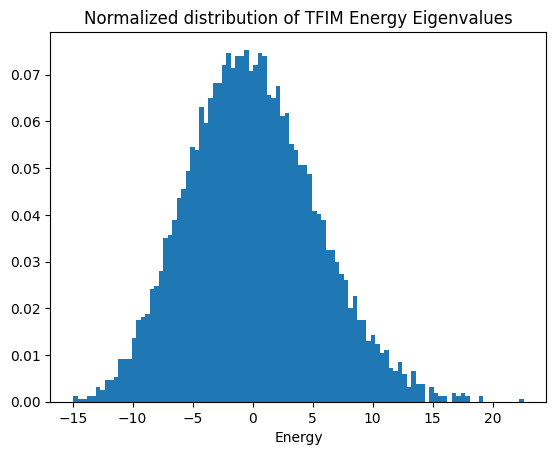

In [ ]:
plt.hist(evals, bins=100, density=True)
plt.title("Normalized distribution of TFIM Energy Eigenvalues")
plt.xlabel("Energy")

b. What is the shape of the DOS? Next week, we will contrast this DOS with that of a dense random matrix, which has a semicircular DOS. [1pt]

The shape of the DOS is Gaussian, which makes sense because our Hamiltonian is a sum of many local Hamiltonians (this is a manifestation of the central limit theorem).

c. The bandwith of a spectrum is defined as the difference in energy between the highest and lowest energy states. How does the bandwidth scale with system size  L ? It is preferred for you to answer this part by general analtyic reasoning, but it is acceptable to answer by simulating different  Ls . [1pt]

> The bandwidth scales linearly in $L$ since energy is an extensive quantity and thus scales with the size of the system. Another way to see this intuitively is that in a system of spins (each with energy +1/2 or - 1/2) the ground state will be around $-L/2$ (spins pointing down) and the excited state will be around $L/2$ (spins pointing up), making the bandwidth $ΔL ∝ L$.

d. How does the standard deviation of the DOS scale with  L ? This represents the energy window where most of the eigenstates live, which scales differently from the bandwidth. It is preferred for you to answer this part by analtyic reasoning, but it is acceptable to answer by simulating different  Ls . Your analytic answer can be given on general terms and does not need to specifically consider details of the model Hamiltonian. [1pt]

> As we explained above we expect the DOS to follow a Gaussian distribution by the central limit theorem. With a Gaussian distribution we have $\sigma ∝ \sqrt{L}$.


e. What is the temperature corresponding to the ground state (i.e. the state at the bottom of the many-body spectrum?) [1pt]


> The temperature corresponding to the ground state is 0. We can consider the ratio of the Boltzmann factors of the ground state and any excited state to make this clear:
$$\frac{p_i}{p_0} = \frac{e^{-\beta E_i}}{e^{-\beta E_0}} = e^{-\beta (E_i - E_0)}$$
As $T\rightarrow0$, $\beta\rightarrow\infty$, and the ratio of probabilities goes to zero unless $i=0$, i.e. the ground state state probability goes to 1 and all other states' probabilities go to zero at $T=0$.




f. What is the energy corresponding to infinite temperature? Where does this energy live in the many-body spectrum? [1pt]

> Infinite temperature corresponds to the energy density with the maximum entropy, i.e. when we have the greatest number of states within a given window of energy. This occurs at the peak of our DOS graph at the $E = 0$ states, because the greatest number of states are within a window of energy around $E=0$.

g. What is the temperature corresponding to the highest excited state (i.e. the state at the top of the many-body spectrum?) [1pt]

> The temperature corrsponding to the highest excited state is $0^-$, because the highest excited state is simply the ground state of $-H$.

h. Consider temperatures $T=0.1, 1, 10, 100, -100, -10, -1, -0.1$. Numerically compute the expectation value of the energy for each of these temperatures. Plot these as (labeled) vertical lines on the DOS plot. Also mark the infinite temperature energy computed in f. [4pts]


In [ ]:
Ts = [0.1, 1, 10, 100, -100, -10, -1, -0.1]
def partition(temp, evals):
  return sum(np.exp([-E/temp for E in evals]))
Zs = partition(Ts, evals)
expectations = []
for i in range(len(Ts)):
  expectations.append(sum([E*np.exp(-E/Ts[i]) for E in evals])/Zs[i])
expectations

NameError: name 'evals' is not defined

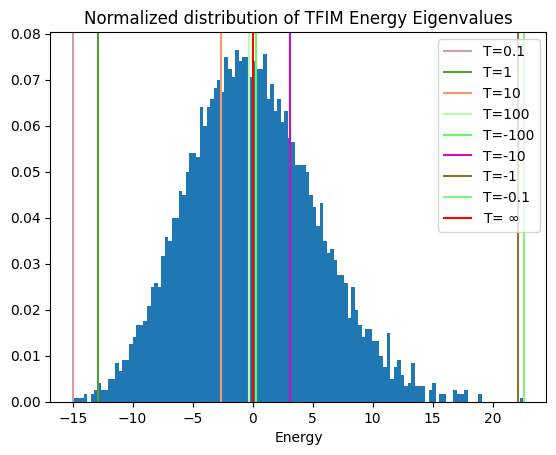

In [ ]:
plt.hist(evals, bins=128, density=True)
plt.title("Normalized distribution of TFIM Energy Eigenvalues")
plt.xlabel("Energy")
colors = np.random.rand(len(Ts), 3)  # RGB colors
for i in range(len(Ts)):
    plt.axvline(x=expectations[i], color=colors[i], label=f'T={Ts[i]}')
plt.axvline(x=0, color='r', label=r'T= $\infty$')
plt.legend()

# Question 2: Diagonal ETH (15 pts)#



We will now verify the (diagonal) ETH for the non-integrable transverse field Ising chain, for a particular local observable $A= \sigma_{L/2}^x$. The statement of diagonal ETH is:

$A_{\alpha \alpha}   = \langle A\rangle_T + O(1/L) +O(e^{-S/2})$ (Equation 1)

where $|\alpha\rangle$ is a many-body eigenstate with eigenenergy $E$, and  $\langle A\rangle_T = \frac{1}{Z}\mbox{Tr } A e^{-H/T}$ is the thermal expectation value of $A$ at a temperature $T$ corresponding to the energy $E$, and $S(E) \propto L$ is the entropy, so that $e^{S(E)}$ is the relevant Hilbert space dimension at energy $E$.

Conditions to verify:
1. The diagonal eigenstate expectation value (EEV) $A_{\alpha\alpha}$ varies smoothly as a function of the energy of the eigenstates.
2. The eigenstate-to-eigenstate fluctuations in the EEVs decrease (exponentially) with increasing system size. Note that this is closely related to point 1. The energy difference between neighboring eigenstates in the middle of the many-body spectrum is exponentially small in $L$. Thus, if $O(E)$ is a smooth function of $E$, we expect differences between nearby eigenstate expectation values to be exponentially close. This is the $O(e^{-S/2})$ part in Equation (1) above. Note that all states within some $O(1)$ energy window $\Delta E$ have the same energy density and hence the same temperature, so $\langle A\rangle_T$ is the same for all states in the window.

2. The eigenstate expectation value of the observable agrees with the expected thermodynamic answer, $\langle A\rangle_T$ at the same temperature. However, note that the difference between the EEV and $\langle A\rangle_T$ only decreases polynomially with $1/L$ (similar in spirit to the agreement between canonical and microcanonical ensembles in standard stat mech, up to poly(1/L) corrections).

Useful references:
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

a. Make scatter plots of $A_{\alpha \alpha}$ vs. $E_\alpha$ for $L=8,10,12$. Do you visually see the distributions narrowing with increasing $L$? You may find the hist2d function in matplotlib useful. (5pts)

b. Pick an array of logarithmically spaced temperatures between 0.1 and $10^{10}$ (check out np.logspace). For each temperature in your list, compute $\langle A\rangle_T$ and  $\langle H\rangle_T$. Plot $\langle A\rangle_T$ vs.  $\langle H\rangle_T$ on the scatter plot in (a) for the largest system size. Does the thermal curve track the scatter plot? (5pts)

c. Set $h_z=0$ and repeat a-c. When $h_z=0$, the model is the TFIM which is an integrable non-interacting model after performing a Jordan-Wigner transformation. Thus, we do not expect ETH to hold for this model, and expect fluctuations to be be much larger. Do you see this?  (5pts)

a. Make scatter plots of $A_{\alpha \alpha}$ vs. $E_\alpha$ for $L=8,10,12$. Do you visually see the distributions narrowing with increasing $L$? You may find the hist2d function in matplotlib useful. (5pts)

> We do indeed see the distribution narrowing for larger $L$.

In [ ]:
def H_eig(l):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(l)
  H = J*gen_interaction_kdist(sz_list,k=1, bc=BC) + hx*gen_op_total(sx_list) + hz*gen_op_total(sz_list)
  evals, evecs = linalg.eigh(H.toarray())
  return evals, evecs

def A_(l):
    return gen_s0sxsysz(l)[1][int(l/2-1)]

def A_aa(l):
  A = A_(l).toarray()
  evals, evecs = H_eig(l)
  return evals, [np.vdot(evecs[i], A@evecs[i]) for i in range(len(evecs))]

Ls = [8, 10, 12]
points = [A_aa(L) for L in Ls]

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

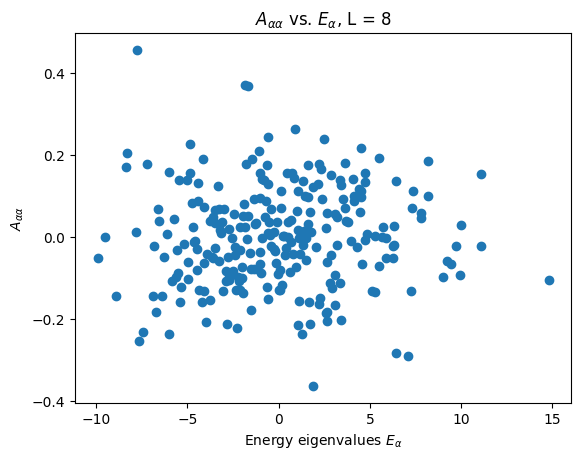

In [ ]:
plt.scatter(points[0][0], points[0][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 8')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

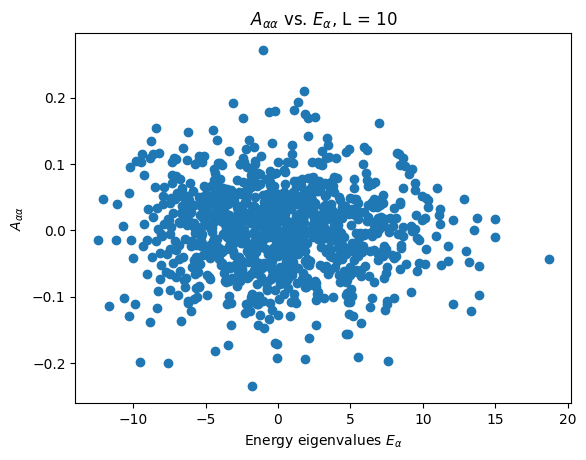

In [ ]:
plt.scatter(points[1][0], points[1][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 10')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

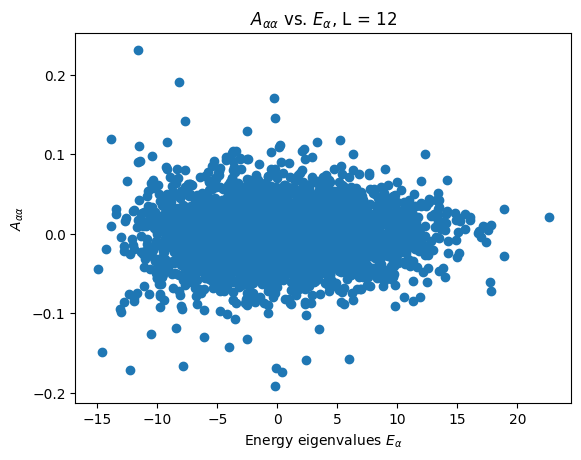

In [ ]:
plt.scatter(points[2][0], points[2][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 12')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

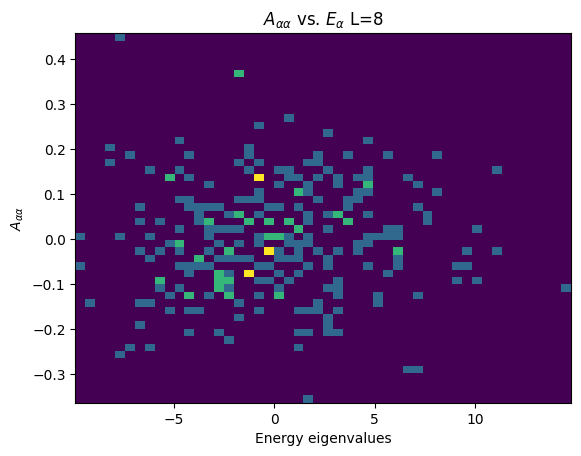

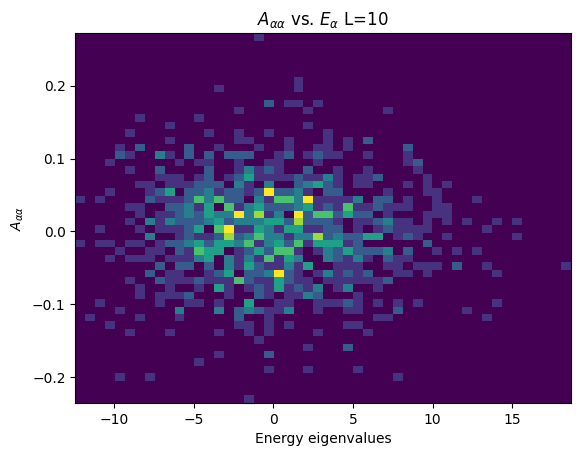

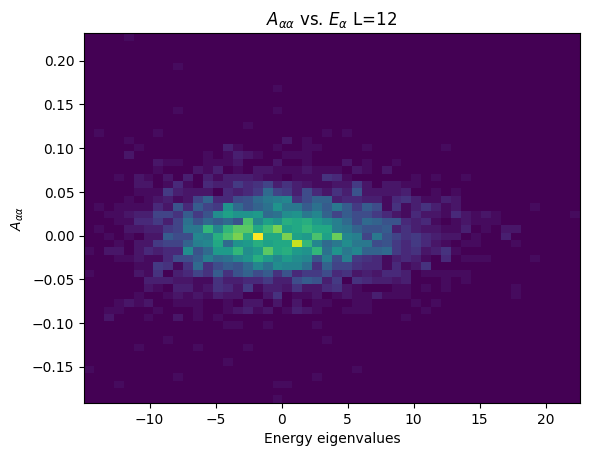

In [ ]:
def plot2dhist(data, l):
  fig,ax = plt.subplots()
  ax.hist2d(data[0], data[1], bins=50, density=True)
  ax.set(xlabel="Energy eigenvalues", ylabel= r'$A_{\alpha \alpha}$', title= r'$A_{\alpha \alpha}$ vs. $E_\alpha$' + f' L={l}')
for i in range(len(Ls)):
  plot2dhist(points[i], Ls[i])

b. Pick an array of logarithmically spaced temperatures between 0.1 and $10^{10}$ (check out np.logspace). For each temperature in your list, compute $\langle A\rangle_T$ and  $\langle H\rangle_T$. Plot $\langle A\rangle_T$ vs.  $\langle H\rangle_T$ on the scatter plot in (a) for the largest system size. Does the thermal curve track the scatter plot? (5pts)

In [ ]:
Ts2 = np.logspace(-1, 10, num=12)
Zs2 = partition(Ts2, evals)
H_expecs = []
for i in range(len(Ts2)):
  H_expecs.append(sum([E*np.exp(-E/Ts2[i]) for E in evals])/Zs2[i])
A12 = A_(12).toarray()

In [ ]:
A_expecs = []
[A_expecs.append((1/partition(T, evals))*np.trace(A12 @ linalg.expm((-H/T).toarray()))) for T in Ts2]

[None, None, None, None, None, None, None, None, None, None, None, None]

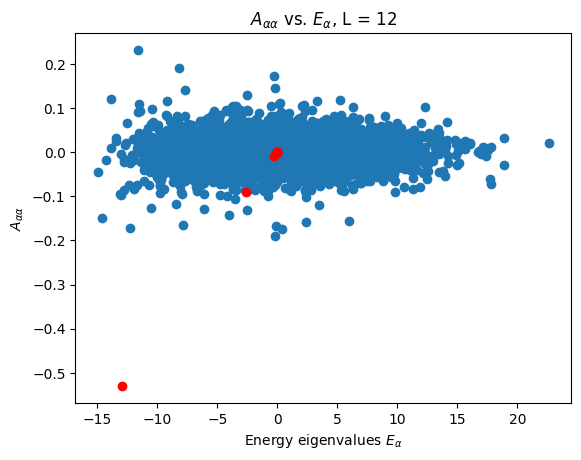

In [ ]:
plt.scatter(points[2][0], points[2][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 12')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')
plt.scatter(H_expecs[1:],A_expecs[1:], color='r')

In [ ]:
(1/partition(0.1, evals))*np.trace(A12 @ linalg.expm((-H/0.1).toarray()))

-0.6956043643234388

In [ ]:
A_expecs

[-0.6956043643234388,
 -0.5296021482606252,
 -0.08948411724121307,
 -0.009044045871536061,
 -0.0009045074509649706,
 -9.045084867181436e-05,
 -9.045084970827743e-06,
 -9.045084971864278e-07,
 -9.045084971874636e-08,
 -9.045084971874737e-09,
 -9.045084971874736e-10,
 -9.045084971874746e-11]

In [ ]:
H_expecs

[-14.955711857442207,
 -1.7237758197470014,
 -0.011410998016404978,
 -7.201999182489217e-05,
 -4.544162765657257e-07,
 -2.8671688608386553e-09]

In [ ]:
Ts2

array([1.00000000e-01, 1.58489319e+01, 2.51188643e+03, 3.98107171e+05,
       6.30957344e+07, 1.00000000e+10])

c. Set $h_z=0$ and repeat a-c. When $h_z=0$, the model is the TFIM which is an integrable non-interacting model after performing a Jordan-Wigner transformation. Thus, we do not expect ETH to hold for this model, and expect fluctuations to be be much larger. Do you see this?  (5pts)

> Yes, we see larger fluctuations.

In [ ]:
hz = 0
points2 = [A_aa(L) for L in Ls]

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

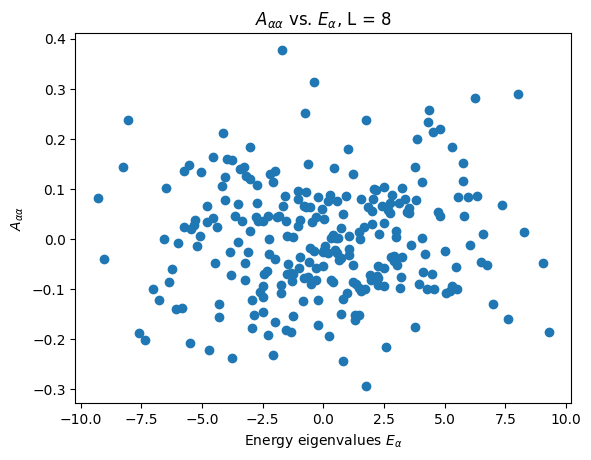

In [ ]:
plt.scatter(points2[0][0], points2[0][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 8')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

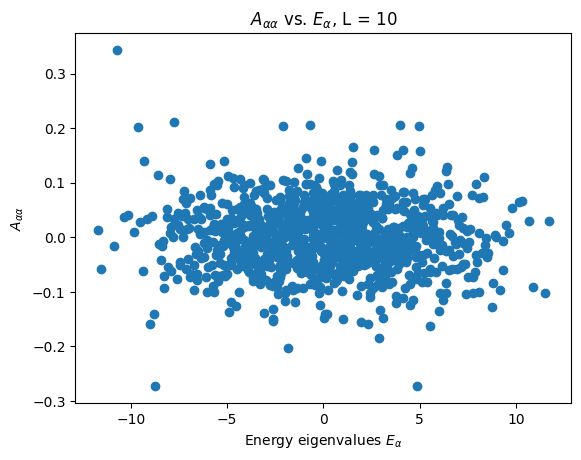

In [ ]:
plt.scatter(points2[1][0], points2[1][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 10')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

Text(0, 0.5, '$A_{\\alpha \\alpha}$')

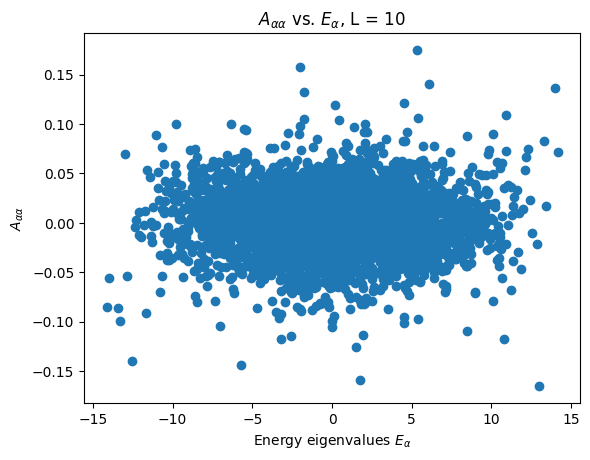

In [ ]:
plt.scatter(points2[2][0], points2[2][1])
plt.title(r'$A_{\alpha \alpha}$ vs. $E_\alpha$, L = 10')
plt.xlabel(r'Energy eigenvalues $E_{\alpha}$')
plt.ylabel(r'$A_{\alpha \alpha}$')

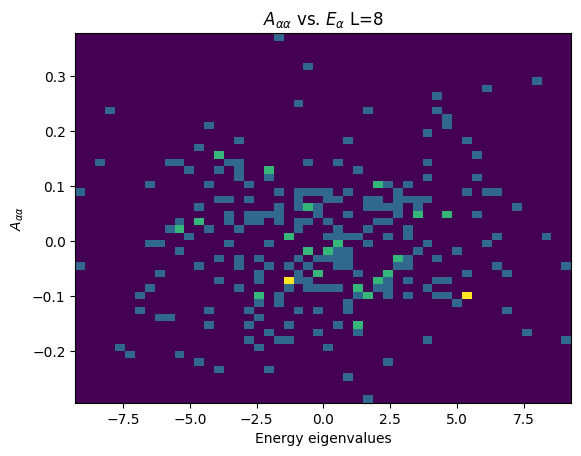

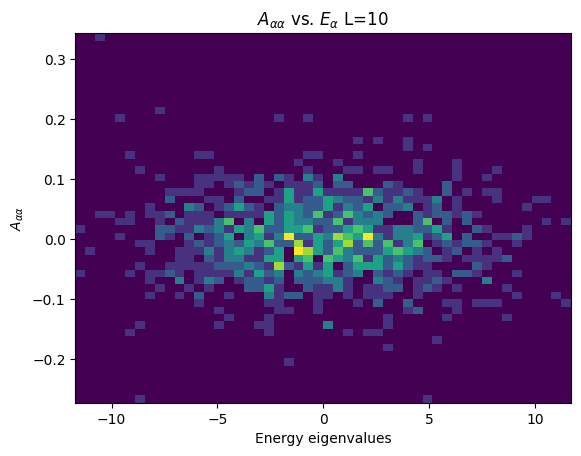

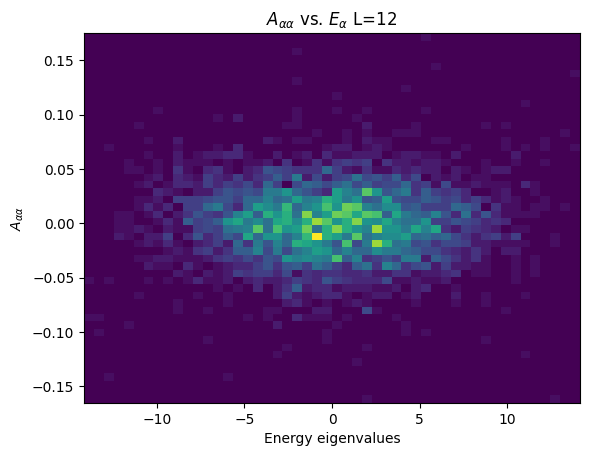

In [ ]:
for i in range(len(Ls)):
  plot2dhist(points2[i], Ls[i])

# Question 3: Quenches (25 pts)#

Next, we will consider dynamics starting from general initial states $|\psi_0\rangle$. Thermalization means $\langle \psi(t)|A|\psi(t)\rangle \rightarrow  \langle A\rangle_T$ at late times, where the temperature is set by the energy density of the initial state. The instantaneous fluctuations in time are again supposed to be exponentially small in $L$, scaling as $e^{-S/2}$.  

a. Fix L=10. Pick initial product states $|\psi_0\rangle $ with different expectation values of energies spanning the spectrum. It is easiest to choose product states in the $Z$ basis, which are of the form $|\uparrow \downarrow \cdots \uparrow\rangle$.  Note that the diagonal entries of $H$ are equal to $\langle n|H|n\rangle$ for product states $|n\rangle$ in the $Z$ basis. By sorting the diagonal entries, pick 10 indices $n$ corresponding to (roughly) equally spaced energy expectation values. Indicate these energies as vertical lines on the DOS. (5pts)

b. Obtain $\langle A\rangle_T$ for each of the initial states you picked in a. Note that it is easiest to do this approximately by picking a finely spaced list of temperatures, and obtaining $\langle A\rangle_T$ and  $\langle H\rangle_T$  for this list, as in Question 2. These parametric plot of $\langle A\rangle_T$ vs  $\langle H\rangle_T$ should look smooth. You can then read off the (interpolated) expected thermal $\langle A\rangle_T$s corresponding to the energies of the different initial states in (a). (5pts)

c. Plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for each of the initial states in (a) on the same plot using different colors. Add dashed lines indicating the expected thermal values. Do the late-time expectation values agree with the thermal values? (5pts)

d. Fix a particular initial state corresponding to infinite temperature, and plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for $L=8,10,12$ on the same plot. Do you see the late time fluctuations narrowing with increasing $L$? Verify that the late-time fluctuations scale as $e^{-S/2}\sim 2^{-L/2}$. (You may find it convenient to start with a $+Y$ product state which is at infinite temperature and can allow you to easily compare across sizes; the gen_state_bloch function will help you obtain such a state). (5pts)

e. No numerics for this part. Expand $\langle \psi(t)|A|\psi(t)\rangle$  in the eigenbasis of the Hamiltonian, separating the sums between time-independent diagonal contributions and the time-dependent off-diagonal ones. Use the ETH ansantz for off-diagonal matrix elements, and assume that your eigenvectors look like random vectors (this is a reasonable approximation for infinite temperature eigenstates which dominate the DOS). By considering the scaling of all the different compnents, show that the instantaneous off-diagonal fluctuation scales as $e^{-S/2}$ for this late time. (5pts)





a. Fix L=10. Pick initial product states $|\psi_0\rangle $ with different expectation values of energies spanning the spectrum. It is easiest to choose product states in the $Z$ basis, which are of the form $|\uparrow \downarrow \cdots \uparrow\rangle$.  Note that the diagonal entries of $H$ are equal to $\langle n|H|n\rangle$ for product states $|n\rangle$ in the $Z$ basis. By sorting the diagonal entries, pick 10 indices $n$ corresponding to (roughly) equally spaced energy expectation values. Indicate these energies as vertical lines on the DOS. (5pts)


In [ ]:
def genH(l):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(l)
  return J*gen_interaction_kdist(sz_list,k=1, bc=BC) + hx*gen_op_total(sx_list) + hz*gen_op_total(sz_list)
H10 = genH(10)

In [ ]:
#Sort and index diagonal entries of H
diagH = np.diagonal(H10.toarray())
sorted_indices = np.argsort(diagH)
sortedDiags = np.array([diagH, np.array(range(0, H10.shape[0]))]).T[sorted_indices]
sortedDiags

array([[ -9.        , 341.        ],
       [ -9.        , 682.        ],
       [ -8.61803399, 853.        ],
       ...,
       [ 13.47213595, 512.        ],
       [ 13.47213595,   1.        ],
       [ 17.09016994,   0.        ]])

In [ ]:
# Find the elements of the diagonal entry closest to 10 equally spaced energies from -11 to 20.7
closest_elements = []
target_numbers = np.linspace(-9, 17.09, num=10)
# Find the closest element for each number in the vector
for target_number in target_numbers:
    absolute_diff = np.abs(sortedDiags[:,0] - target_number)
    closest_index = np.argmin(absolute_diff)
    closest_elements.append(sortedDiags[closest_index])
#Energies are first column, indicies n are second column
closest_elements = np.vstack(closest_elements)
closest_elements

array([[-9.00000000e+00,  3.41000000e+02],
       [-6.23606798e+00,  7.31000000e+02],
       [-3.38196601e+00,  6.76000000e+02],
       [-2.36067977e-01,  1.01200000e+03],
       [ 2.61803399e+00,  5.80000000e+01],
       [ 5.38196601e+00,  1.00800000e+03],
       [ 8.23606798e+00,  5.15000000e+02],
       [ 1.14721360e+01,  1.28000000e+02],
       [ 1.34721360e+01,  5.12000000e+02],
       [ 1.70901699e+01,  0.00000000e+00]])

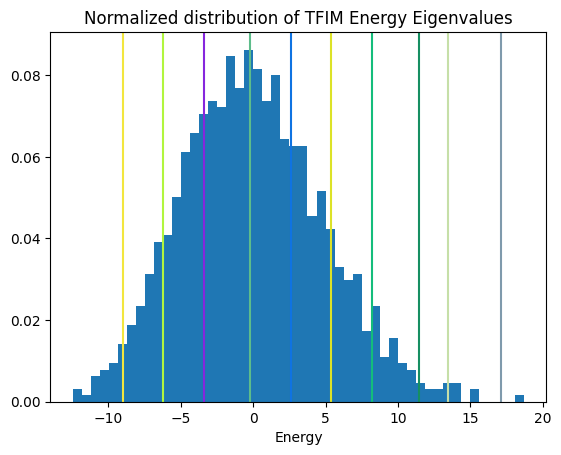

In [ ]:
evals10, evecs10 = H_eig(10)
plt.hist(evals10, bins=50, density=True)
plt.title("Normalized distribution of TFIM Energy Eigenvalues")
plt.xlabel("Energy")
colors = np.random.rand(len(closest_elements), 3)  # RGB colors
for i in range(len(closest_elements)):
    plt.axvline(x=closest_elements[i][0], color=colors[i])

b. Obtain $\langle A\rangle_T$ for each of the initial states you picked in a. Note that it is easiest to do this approximately by picking a finely spaced list of temperatures, and obtaining $\langle A\rangle_T$ and  $\langle H\rangle_T$  for this list, as in Question 2. These parametric plot of $\langle A\rangle_T$ vs  $\langle H\rangle_T$ should look smooth. You can then read off the (interpolated) expected thermal $\langle A\rangle_T$s corresponding to the energies of the different initial states in (a). (5pts)

> We use a quadratic fit to interpolate our ATs

In [ ]:
Ts3 = np.linspace(-10,10, num=20)
Zs3 = partition(Ts3, evals10)
H_expecs2 = []
for i in range(len(Ts3)):
  H_expecs2.append(sum([E*np.exp(-E/Ts3[i]) for E in evals10])/Zs3[i])
A10 = A_(10).toarray()

In [ ]:
A_expecs2 = []
[A_expecs2.append((1/partition(T, evals10))*np.trace(A10 @ linalg.expm((-H10/T).toarray()))) for T in Ts3]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

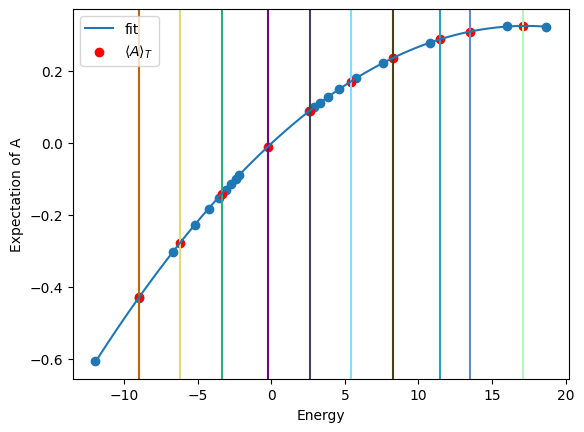

In [ ]:
plt.scatter(H_expecs2, A_expecs2)
plt.xlabel('Energy')
plt.ylabel('Expectation of A')
colors = np.random.rand(len(closest_elements), 3)  # RGB colors
for i in range(len(closest_elements)):
    plt.axvline(x=closest_elements[i][0], color=colors[i])

# Fit a quadratic function to the data points
coefficients = np.polyfit(H_expecs2, A_expecs2, 2)  # Fit a quadratic (degree 2) polynomial

# Create a polynomial function using the fitted coefficients
quadratic_function = np.poly1d(coefficients)

# Generate points for the fitted curve
x_fit = np.linspace(min(H_expecs2), max(H_expecs2), 100)
y_fit = quadratic_function(x_fit)
plt.plot(x_fit, y_fit, label = 'fit')
A_Ts = quadratic_function(closest_elements[:,0])
plt.scatter(closest_elements[:,0], A_Ts, color='r', label = r'$\langle A\rangle_T$')
plt.legend()

In [ ]:
A_Ts

array([-0.42921223, -0.27902953, -0.14142619, -0.0103304 ,  0.08993842,
        0.17011276,  0.23542381,  0.28799188,  0.30906523,  0.32502998])

c. Plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for each of the initial states in (a) on the same plot using different colors. Add dashed lines indicating the expected thermal values. Do the late-time expectation values agree with the thermal values? (5pts)


In [ ]:
H10.shape[0]

1024

In [ ]:
evecs10.T

array([[ 2.05901914e-04, -6.02542583e-04, -6.31498516e-04, ...,
        -2.96514724e-02, -1.16495210e-02,  1.52403211e-02],
       [ 0.00000000e+00,  1.65807939e-04, -3.12186382e-04, ...,
         9.59340645e-03, -2.93437023e-03,  1.13841228e-17],
       [-8.88652729e-05,  4.45002628e-07,  7.12001643e-04, ...,
        -1.42581198e-02,  6.48582317e-03, -1.02275431e-03],
       ...,
       [-8.02511928e-10, -5.43024340e-01, -9.51983093e-02, ...,
         3.13246015e-05,  4.38590470e-05,  1.29711780e-13],
       [ 3.21301573e-01, -4.65199442e-01, -4.27050338e-02, ...,
        -6.69063013e-05, -6.69326366e-05, -5.19078738e-05],
       [ 8.46653322e-01,  2.05069380e-01,  1.38325045e-01, ...,
         5.61336840e-06,  6.32677064e-06,  2.96302839e-06]])

In [ ]:
phases = np.exp(-1j*t*evals10)


1.0

In [ ]:
linalg.expm(-1j*1*H10.toarray())

array([[ 0.68160801+6.97288685e-03j,  0.27759465+8.23185715e-02j,
         0.08656526-6.68210333e-03j, ...,  0.00222701+2.58467729e-03j,
         0.00374995+4.31699530e-03j,  0.00930225+8.81622015e-04j],
       [ 0.27759465+8.23185715e-02j, -0.28629641-4.44476535e-01j,
         0.00968331+2.03808704e-01j, ...,  0.00530435-6.11558985e-03j,
         0.00616105+8.36820758e-03j, -0.01137182+3.14201196e-03j],
       [ 0.08656526-6.68210333e-03j,  0.00968331+2.03808704e-01j,
         0.38479112-4.63730056e-02j, ..., -0.00217783+1.11040096e-02j,
         0.00641745-1.42581784e-02j, -0.01564848-2.50020546e-04j],
       ...,
       [ 0.00222701+2.58467729e-03j,  0.00530435-6.11558985e-03j,
        -0.00217783+1.11040096e-02j, ...,  0.11019413+7.06194854e-02j,
         0.01989546+7.91683676e-02j, -0.04992398-2.79680121e-02j],
       [ 0.00374995+4.31699530e-03j,  0.00616105+8.36820758e-03j,
         0.00641745-1.42581784e-02j, ...,  0.01989546+7.91683676e-02j,
        -0.03333565-8.40054516e-02j

In [ ]:
y = np.zeros(H10.shape[0])
y[341] = 1
ts = np.linspace(0, 10, 30)
result = []
for t in ts:
  evol = linalg.expm(-1j*t*H10.toarray())
  result.append(np.vdot(y,evol.conj().T@A10@evol@y))
plt.plot(ts, result)

NameError: name 'np' is not defined

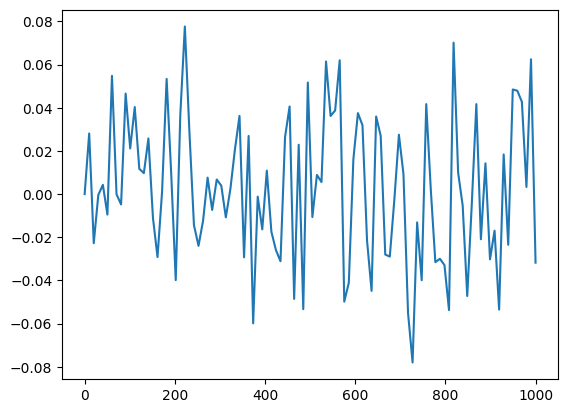

In [ ]:

y = np.zeros(H10.shape[0])
y[341] = 1
coeffs = np.zeros(H10.shape[0])
for i in range(1024):
  coeffs[i] = np.vdot(evecs10[i], y)

ts = np.linspace(0, 1000, 100)
expAs = []


for t in ts:
  phases = np.exp(-1j*t*evals10)
  psit = np.zeros(1024)
  for n in range(1024):
    psit = psit + np.exp(-1j*t*evals10[n])*np.vdot(evecs10[n], y)*evecs10[n]
  #psit = evecs10.T @ (phases*coeffs)
  expAs.append(np.vdot(psit, A10@psit))

plt.plot(ts, expAs)

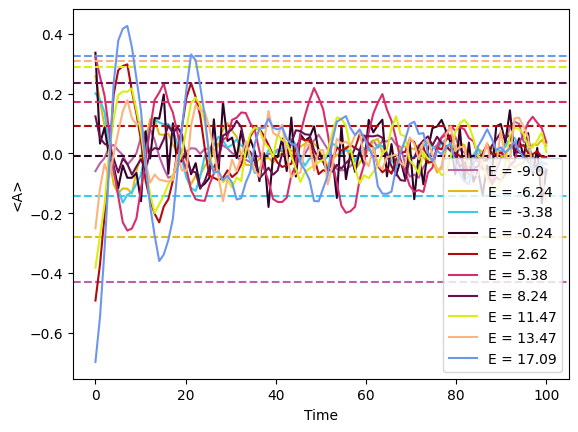

In [ ]:
#Loop over equally spaced energies
for i in range(10):
  #Inner product initial state with eigenvectors to get coefficients
  y = np.zeros(H10.shape[0])
  y[int(closest_elements[i][1])] = 1
  coeffs_ = np.zeros(H10.shape[0])
  for j in range(1024):
    coeffs_[j] = np.vdot(evecs10[j], y)

  #Multiply in phase factors due to time evolution
  ts = np.linspace(0, 100, 100)
  expAs = []
  for t in ts:
    phases_ = np.exp(-1j*t*evals10)
    psit_ = phases_*coeffs_
    #Compute <A> for each time t
    expAs.append(np.vdot(psit_, A10@psit_))

  #plot
  plt.xlabel('Time')
  plt.ylabel('<A>')
  color = np.random.rand(3)  # RGB colors
  plt.axhline(y=A_Ts[i], color=color, ls='--')
  plt.plot(ts, expAs, color = color, label=f'E = {round(closest_elements[i][0],2)}')
  plt.legend()


